## Pre-processing
- One-hot encode categorical variables.
- Train/test split your data.
- Scale your data.
- Consider using automated feature selection.

## Modeling
- **Establish your baseline score.**
- Fit linear regression. Look at your coefficients. Are any of them wildly overblown?
- Fit lasso/ridge/elastic net with default parameters.
- Go back and remove features that might be causing issues in your models.
- Tune hyperparameters.
- **Identify a production model.** (This does not have to be your best performing Kaggle model, but rather the model that best answers your problem statement.)
- Refine and interpret your production model.


In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures 

import statsmodels.api as sm
import math


In [2]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [3]:
housing = pd.read_csv('./housing2.csv', low_memory=False)
housing.head()

Unnamed: 0 flat_type  flat_model  resale_price  Tranc_Year  \
0           0    4 ROOM     Model A      680000.0        2016   
1           1    5 ROOM    Improved      665000.0        2012   
2           3    4 ROOM     Model A      550000.0        2012   
3           4    4 ROOM  Simplified      298000.0        2017   
4           5    3 ROOM    Improved      335000.0        2013   

   floor_area_sqft commercial planning_area  Mall_Nearest_Distance  \
0         6.876017          N       Kallang               6.997679   
1         7.243742          N        Bishan               6.764971   
2         7.010936          Y        Bishan               6.856646   
3         6.795048          N        Yishun               6.592732   
4         6.550595          Y       Geylang               6.527964   

   Mall_Within_2km  Hawker_Nearest_Distance  Hawker_Within_2km  \
0         1.945910                 5.041833           2.564949   
1         1.098612                 6.461706           1.945910   
2         1.386294                 6.587846           2.197225   
3         0.693147                 7.339636           0.000000   
4         1.791759                 5.000034           2.397895   

   hawker_food_stalls  hawker_market_stalls  mrt_nearest_distance  \
0            4.430817              4.094345              5.799344   
1            4.382027              4.343805              6.806453   
2            3.465736              4.454347              6.810642   
3            3.806662             -4.605170              6.021856   
4            4.369448              4.406719              6.519577   

   bus_stop_nearest_distance  pri_sch_nearest_distance  sec_sch_nearest_dist  \
0                   3.381926                  7.037584              7.037584   
1                   4.064019                  6.029741              6.104557   
2                   3.770379                  5.964904              5.964904   
3                   4.863084                  5.994462              5.743085   
4                   5.436689                  6.387096              6.411553   

   distance_from_CBD  1_2_3_rooms_sold  4_5_other_rooms_sold  est_floor_level  \
0           1.261663         -4.605170              4.955827         2.397895   
1           0.851318         -4.605170              4.718499         2.079442   
2           0.799040         -4.605170              4.317488         1.098612   
3           1.328843         -4.605170              3.871201         0.693147   
4           1.612590          5.236442              1.609438         2.079442   

   age_at_sale  
0     2.302585  
1     3.218876  
2     2.995732  
3     3.401197  
4     3.637586

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144640 entries, 0 to 144639
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Unnamed: 0                 144640 non-null  int64  
 1   flat_type                  144640 non-null  object 
 2   flat_model                 144640 non-null  object 
 3   resale_price               144640 non-null  float64
 4   Tranc_Year                 144640 non-null  int64  
 5   floor_area_sqft            144640 non-null  float64
 6   commercial                 144640 non-null  object 
 7   planning_area              144640 non-null  object 
 8   Mall_Nearest_Distance      144640 non-null  float64
 9   Mall_Within_2km            144640 non-null  float64
 10  Hawker_Nearest_Distance    144640 non-null  float64
 11  Hawker_Within_2km          144640 non-null  float64
 12  hawker_food_stalls         144640 non-null  float64
 13  hawker_market_stalls       14

In [5]:
# Identifying categorical predictors for one-hot encoding

numerical_var = housing.select_dtypes(include=['number'])
numerical_var.columns

Index(['Unnamed: 0', 'resale_price', 'Tranc_Year', 'floor_area_sqft',
       'Mall_Nearest_Distance', 'Mall_Within_2km', 'Hawker_Nearest_Distance',
       'Hawker_Within_2km', 'hawker_food_stalls', 'hawker_market_stalls',
       'mrt_nearest_distance', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'sec_sch_nearest_dist', 'distance_from_CBD',
       '1_2_3_rooms_sold', '4_5_other_rooms_sold', 'est_floor_level',
       'age_at_sale'],
      dtype='object')

In [6]:
numerical_var.drop(columns = ['resale_price','Unnamed: 0'], inplace = True)

In [7]:
# Standardising predictors

ss = StandardScaler()
num_ss = ss.fit_transform(numerical_var)
num_ss = pd.DataFrame(num_ss, columns = numerical_var.columns)

### Pre-Processing

In [8]:
# Converting the following variables to categorical 

housing['Tranc_Year'] = housing['Tranc_Year'].astype('object')

In [9]:
# Identifying categorical predictors for one-hot encoding

categorical_var = housing.select_dtypes(include=['object'])
categorical_var.columns

Index(['flat_type', 'flat_model', 'Tranc_Year', 'commercial', 'planning_area'], dtype='object')

In [10]:
categorical_var = housing.select_dtypes(include=['object'])
categorical_var.head()

flat_type  flat_model Tranc_Year commercial planning_area
0    4 ROOM     Model A       2016          N       Kallang
1    5 ROOM    Improved       2012          N        Bishan
2    4 ROOM     Model A       2012          Y        Bishan
3    4 ROOM  Simplified       2017          N        Yishun
4    3 ROOM    Improved       2013          Y       Geylang

In [11]:
# Dummifying all categorical variables

categorical_var = pd.get_dummies(columns=categorical_var.columns,data=housing, drop_first=True)

/var/folders/r9/9246nqp9249ghjl6r9xy_dwr0000gn/T/ipykernel_8318/1831883889.py:3: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  categorical_var = pd.get_dummies(columns=categorical_var.columns,data=housing, drop_first=True)


In [12]:
housing = pd.concat([num_ss, categorical_var], axis=1)

In [13]:
housing.drop(columns = "Unnamed: 0", inplace = True)

In [14]:
housing.head()

Tranc_Year  floor_area_sqft  Mall_Nearest_Distance  Mall_Within_2km  \
0   -0.160166        -0.138635               1.066187         0.658036   
1   -1.617931         1.281303               0.692462        -0.532074   
2   -1.617931         0.382345               0.839691        -0.127997   
3    0.204275        -0.451290               0.415847        -1.101588   
4   -1.253490        -1.395227               0.311830         0.441517   

   Hawker_Nearest_Distance  Hawker_Within_2km  hawker_food_stalls  \
0                -1.654436           1.063531            0.873885   
1                -0.200632           0.807824            0.808747   
2                -0.071477           0.911634           -0.414573   
3                 0.698278           0.004023            0.040590   
4                -1.697233           0.994526            0.791953   

   hawker_market_stalls  mrt_nearest_distance  bus_stop_nearest_distance  \
0              0.716006             -1.156403                  -2.383493   
1              0.772368              0.534001                  -1.071584   
2              0.797344              0.541033                  -1.636358   
3             -1.249519             -0.782924                   0.465305   
4              0.786583              0.052488                   1.568553   

   pri_sch_nearest_distance  sec_sch_nearest_dist  distance_from_CBD  \
0                  2.133487              1.674724          -0.944602   
1                  0.373422              0.086207          -1.573922   
2                  0.260192             -0.151560          -1.654098   
3                  0.311811             -0.529216          -0.841573   
4                  0.997495              0.608879          -0.406407   

   1_2_3_rooms_sold  4_5_other_rooms_sold  est_floor_level  age_at_sale  \
0         -0.773386              0.607487         0.770665    -1.090841   
1         -0.773386              0.481780         0.312031     0.296443   
2         -0.773386              0.269374        -1.100550    -0.041401   
3         -0.773386              0.032987        -1.684497     0.572482   
4          1.452160             -1.165014         0.312031     0.930380   

   resale_price  floor_area_sqft  Mall_Nearest_Distance  Mall_Within_2km  \
0      680000.0         6.876017               6.997679         1.945910   
1      665000.0         7.243742               6.764971         1.098612   
2      550000.0         7.010936               6.856646         1.386294   
3      298000.0         6.795048               6.592732         0.693147   
4      335000.0         6.550595               6.527964         1.791759   

   Hawker_Nearest_Distance  Hawker_Within_2km  hawker_food_stalls  \
0                 5.041833           2.564949            4.430817   
1                 6.461706           1.945910            4.382027   
2                 6.587846           2.197225            3.465736   
3                 7.339636           0.000000            3.806662   
4                 5.000034           2.397895            4.369448   

   hawker_market_stalls  mrt_nearest_distance  bus_stop_nearest_distance  \
0              4.094345              5.799344                   3.381926   
1              4.343805              6.806453                   4.064019   
2              4.454347              6.810642                   3.770379   
3             -4.605170              6.021856                   4.863084   
4              4.406719              6.519577                   5.436689   

   pri_sch_nearest_distance  sec_sch_nearest_dist  distance_from_CBD  \
0                  7.037584              7.037584           1.261663   
1                  6.029741              6.104557           0.851318   
2                  5.964904              5.964904           0.799040   
3                  5.994462              5.743085           1.328843   
4                  6.387096              6.411553           1.612590   

   1_2_3_rooms_sold  4_5_other_rooms_sol

In [15]:
housing.describe(include = 'all')

Tranc_Year  floor_area_sqft  Mall_Nearest_Distance  Mall_Within_2km  \
count  1.446400e+05     1.446400e+05           1.446400e+05     1.446400e+05   
mean  -4.061938e-14    -2.927845e-16           1.796056e-15    -1.627017e-16   
std    1.000003e+00     1.000003e+00           1.000003e+00     1.000003e+00   
min   -1.617931e+00    -4.254220e+00          -1.756786e+01    -8.543577e+00   
25%   -8.890485e-01    -8.944866e-01          -5.843840e-01    -5.320738e-01   
50%    2.042750e-01     2.927897e-02           1.137264e-01     1.854292e-01   
75%    9.331573e-01     6.711832e-01           6.959347e-01     4.415171e-01   
max    1.662040e+00     2.787105e+00           2.932043e+00     3.207783e+00   

       Hawker_Nearest_Distance  Hawker_Within_2km  hawker_food_stalls  \
count             1.446400e+05       1.446400e+05        1.446400e+05   
mean             -1.036143e-15      -3.536994e-18        1.026514e-15   
std               1.000003e+00       1.000003e+00        1.000003e+00   
min              -6.174053e+00      -1.898244e+00       -1.118987e+01   
25%              -7.326821e-01       4.022781e-03       -1.166593e-01   
50%               3.283180e-02       2.903424e-01       -2.010553e-02   
75%               8.105158e-01       7.441482e-01        4.246685e-01   
max               1.865598e+00       1.220288e+00        2.195237e+00   

       hawker_market_stalls  mrt_nearest_distance  bus_stop_nearest_distance  \
count          1.446400e+05          1.446400e+05               1.446400e+05   
mean          -2.859070e-17         -9.897687e-16              -1.234558e-15   
std            1.000003e+00          1.000003e+00               1.000003e+00   
min           -1.249519e+00         -5.704396e+00              -4.661824e+00   
25%           -1.249519e+00         -5.836748e-01              -5.852302e-01   
50%            6.655904e-01          8.536791e-02               1.095461e-01   
75%            8.291491e-01          6.766350e-01               7.004766e-01   
max            1.184409e+00          2.827971e+00               2.836153e+00   

       pri_sch_nearest_distance  sec_sch_nearest_dist  distance_from_CBD  \
count              1.446400e+05          1.446400e+05       1.446400e+05   
mean              -6.446171e-16          5.131097e-16       1.355848e-16   
std                1.000003e+00          1.000003e+00       1.000003e+00   
min               -3.483145e+00         -4.073475e+00      -1.867284e+01   
25%               -6.882688e-01         -6.669764e-01      -5.865487e-01   
50%                5.870980e-02          7.334210e-02       1.775035e-01   
75%                6.974868e-01          6.863644e-01       7.535930e-01   
max                3.994874e+00          3.652865e+00       1.514858e+00   

       1_2_3_rooms_sold  4_5_other_rooms_sold  est_floor_level   age_at_sale  \
count      1.446400e+05          1.446400e+05     1.446400e+05  1.446400e+05   
mean      -3.094869e-17          1.690879e-16     1.739022e-16 -4.855506e-16   
std        1.000003e+00          1.000003e+00     1.000003e+00  1.000003e+00   
min       -7.733860e-01         -4.456741e+00    -1.684497e+00 -4.577006e+00   
25%       -7.733860e-01         -1.310104e-02    -3.648641e-01 -4.769580e-01   
50%       -7.733860e-01          3.418652e-01     3.120307e-01  2.964434e-01   
75%        1.215443e+00          4.722359e-01     7.706647e-01  7.167841e-01   
max        1.685681e+00          1.139905e+00     2.665490e+00  1.462404e+00   

        resale_price  floor_area_sqft  Mall_Nearest_Distance  Mall_Within_2km  \
count  144640.000000    144640.000000          144640.000000    144640.000000   
mean   433821.778590         6.911920               6.333797         1.477422   
std    121070.637266         0.258973               0.622671         0.711952   
min    150000.000000         5.810194              -4.605170        -4.605170   
25%    345000.000000         6.680272               5.969919         1.098612   
50%    417000.000

In [16]:
housing.shape

(144640, 99)

### Train Test Split

In [17]:
# Identifying X and y variables

X = housing.drop(columns = 'resale_price')
y = housing['resale_price']

In [18]:
# # Instantiate our PolynomialFeatures object to create all two-way terms.
# poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# # Fit and transform our X data.
# X_overfit = poly.fit_transform(X)

In [19]:
#poly.get_feature_names_out(X.columns)

In [20]:
# Train-test-split  

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

### Baseline Score

In [21]:
# Mean resale price 

mean = np.mean(y_train)
mean

433917.48494597414

In [22]:
pred = [mean for x in y_train]

In [23]:
# Baseline model RMSE

baseline_rmse = np.sqrt(np.mean((pred-y_train)**2))
print(f'Baseline RMSE: {baseline_rmse}')

Baseline RMSE: 121149.0294313169


### Linear Regression

In [24]:
# Instantiating logistic regression model

lr_model = LinearRegression()

In [25]:
# Fitting
lr_model.fit(X_train,y_train)

LinearRegression()

In [26]:
# Returning the R^2 for the model

#Training set R2
print('Training set R^2: ', lr_model.score(X_train, y_train))

#Test set R2
print('Test set R^2: ', lr_model.score(X_test, y_test))

Training set R^2:  0.8706378809011609
Test set R^2:  0.8712428087363683


In [27]:
# Cross validation

lr_model_scores = cross_val_score(lr_model, X_train, y_train, cv=10)

print (lr_model_scores)
print (np.mean(lr_model_scores))

[0.86798219 0.87198338 0.86671144 0.86726767 0.87317661 0.86984178
 0.86857979 0.87226009 0.87298074 0.87289726]
0.8703680956757787


In [28]:
# Summary results with p-value 

X_train_lr = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_train_lr).fit()
ols.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     8408.
Date:                Mon, 06 Feb 2023   Prob (F-statistic):               0.00
Time:                        11:01:10   Log-Likelihood:            -1.2252e+06
No. Observations:              101248   AIC:                         2.451e+06
Df Residuals:                  101166   BIC:                         2.451e+06
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                  2.121e+12    4.1e+12      0.518      0.605   -5.91e+12    1.02e+13
Tranc_Year                             4.349e+13   1.53e+14      0.285      0.776   -2.56e+14    3.43e+14
floor_area_sqft                        5.704e+12    2.1e+13      0.272      0.786   -3.54e+13    4.68e+13
Mall_Nearest_Distance                 -5.267e+12   1.12e+13     -0.471      0.638   -2.72e+13    1.67e+13
Mall_Within_2km                       -1.047e+13   2.33e+13     -0.449      0.653   -5.61e+13    3.52e+13
Hawker_Nearest_Distance               -1.317e+13   3.25e+13     -0.405      0.685   -7.69e+13    5.06e+13
Hawker_Within_2km                       8.06e+14   2.83e+15      0.285      0.775   -4.73e+15    6.34e+15
hawker_food_stalls                    -7.359e+12   4.12e+13     -0.179      0.858    -8.8e+13    7.33e+13
hawker_market_stalls                  -7.518e+13   2.64e+14     -0.285      0.775   -5.92e+14    4.41e+14
mrt_nearest_distance                  -8.105e+12   1.57e+13     -0.515      0.606   -3.89e+13    2.27e+13
bus_stop_nearest_distance             -4.193e+12   8.14e+12     -0.515      0.607   -2.01e+13    1.18e+13
pri_sch_nearest_distance              -8.494e+12   1.85e+13     -0.460      0.645   -4.47e+13    2.77e+13
sec_sch_nearest_dist                  -6.616e+12   1.31e+13     -0.505      0.614   -3.23e+13    1.91e+13
distance_from_CBD                      3.771e+12   1.65e+13      0.229      0.819   -2.85e+13    3.61e+13
1_2_3_rooms_sold                       8.579e+13   3.09e+14      0.278      0.781   -5.19e+14    6.91e+14
4_5_other_rooms_sold                   6.366e+13   2.24e+14      0.284      0.777   -3.76e+14    5.04e+14
est_floor_level                        2.421e+13   8.34e+13      0.290      0.772   -1.39e+14    1.88e+14
age_at_sale                            2.173e+13   6.87e+13      0.316      0.752   -1.13e+14    1.56e+14
floor_area_sqft                       -2.202e+13   8.09e+13     -0.272      0.786   -1.81e+14    1.37e+14
Mall_Nearest_Distance                  8.458e+12    1.8e+13      0.471      0.638   -2.68e+13    4.37e+13
Mall_Within_2km                        1.471e+13   3.27e+13      0.449      0.653   -4.94e+13    7.88e+13
Hawker_Nearest_Distance                1.349e+13   3.33e+13      0.405      0.685   -5.18e+13    7.87e+13
Hawker_Within_2km                     -3.329e+14   1.17e+15     -0.285      0.775   -2.62e+15    1.95e+15
hawker_food_stalls                     9.824e+12    5.5e+13      0.179      0.858   -9.79e+13    1.18e+14
hawker_market_stalls                   1.699e+13   5.95e+13      0.285      0.775   -9.97e+13    1.34e+14
mrt_nearest_distance                    1.36e+13   2.64e+13      0.515      0.606   -3.82e+13    6.54e+13
bus_stop_

In [29]:
# Function for obtaining coefficient names, values and p-values from OLS model:

def get_coef_table(lin_reg, variable):
    err_series = lin_reg.params - lin_reg.conf_int()[0]
    
    coef_df = pd.DataFrame({'varname': variable.columns,
                            'coef': lin_reg.params.values[1:],
                            'ci_err': err_series.values[1:],
                            'pvalue': lin_reg.pvalues.round(4).values[1:]
                           })
    return coef_df

In [30]:
pd.set_option('display.max_rows', None)
get_coef_table(ols, X)

varname          coef        ci_err  pvalue
0                              Tranc_Year  4.348912e+13  2.994547e+14  0.7759
1                         floor_area_sqft  5.703726e+12  4.108399e+13  0.7855
2                   Mall_Nearest_Distance -5.266789e+12  2.193653e+13  0.6379
3                         Mall_Within_2km -1.047014e+13  4.565836e+13  0.6531
4                 Hawker_Nearest_Distance -1.317196e+13  6.372641e+13  0.6854
5                       Hawker_Within_2km  8.059991e+14  5.537716e+15  0.7754
6                      hawker_food_stalls -7.358690e+12  8.068883e+13  0.8581
7                    hawker_market_stalls -7.518177e+13  5.165302e+14  0.7754
8                    mrt_nearest_distance -8.105268e+12  3.084127e+13  0.6065
9               bus_stop_nearest_distance -4.192556e+12  1.595392e+13  0.6065
10               pri_sch_nearest_distance -8.494141e+12  3.617670e+13  0.6454
11                   sec_sch_nearest_dist -6.616344e+12  2.569049e+13  0.6137
12                      distance_from_CBD  3.770814e+12  3.230299e+13  0.8190
13                       1_2_3_rooms_sold  8.578582e+13  6.052528e+14  0.7812
14                   4_5_other_rooms_sold  6.365746e+13  4.398961e+14  0.7767
15                        est_floor_level  2.420802e+13  1.635061e+14  0.7717
16                            age_at_sale  2.172587e+13  1.346560e+14  0.7518
17                        floor_area_sqft -2.202446e+13  1.586424e+14  0.7855
18                  Mall_Nearest_Distance  8.458404e+12  3.522982e+13  0.6379
19                        Mall_Within_2km  1.470631e+13  6.413149e+13  0.6531
20                Hawker_Nearest_Distance  1.348673e+13  6.524927e+13  0.6854
21                      Hawker_Within_2km -3.329356e+14  2.287475e+15  0.7754
22                     hawker_food_stalls  9.824429e+12  1.077259e+14  0.8581
23                   hawker_market_stalls  1.698620e+13  1.167023e+14  0.7754
24                   mrt_nearest_distance  1.360447e+13  5.176623e+13  0.6065
25              bus_stop_nearest_distance  8.063787e+12  3.068510e+13  0.6065
26               pri_sch_nearest_distance  1.483390e+13  6.317783e+13  0.6454
27                   sec_sch_nearest_dist  1.126461e+13  4.373917e+13  0.6137
28                      distance_from_CBD -5.783059e+12  4.954105e+13  0.8190
29                       1_2_3_rooms_sold -1.939929e+13  1.368696e+14  0.7812
30                   4_5_other_rooms_sold -3.371781e+13  2.330023e+14  0.7767
31                        est_floor_level -3.486416e+13  2.354800e+14  0.7717
32                            age_at_sale -3.289345e+13  2.038722e+14  0.7518
33                       flat_type_2 ROOM -5.561497e+04  1.207789e+04  0.0000
34                       flat_type_3 ROOM -6.435343e+04  1.230298e+04  0.0000
35                       flat_type_4 ROOM -4.560016e+04  1.294806e+04  0.0000
36                       flat_type_5 ROOM -7.999009e+03  1.357548e+04  0.2481
37                    flat_type_EXECUTIVE  2.378121e+04  1.405373e+04  0.0009
38             flat_type_MULTI-GENERATION  1.470139e+11  1.008862e+12  0.7752
39               flat_model_Adjoined flat  1.825866e+03  6.096395e+04  0.9532
40                   flat_model_Apartment -1.456932e+04  6.054714e+04  0.6372
41                        flat_model_DBSS  7.797302e+04  6.056966e+04  0.0116
42                    flat_model_Improved -5.399980e+04  6.047574e+04  0.0801
43         flat_model_Improved-Maisonette  1.258149e+05  6.466489e+04  0.0001
44                  flat_model_Maisonette  6.803336e+03  6.055871e+04  0.8257
45                     flat_model_Model A -3.897700e+04  6.046887e+04  0.2065
46          flat_model_Model A-Maisonette  2.953573e+04  6.097000e+04  0.3424
47                    flat_model_Model A2 -3.533274e+04  6.051437e+04  0.2525
48            flat_model_Multi Generation -1.470138e+11  1.008862e+12  0.7752
49              flat_model_New Generation -4.731992e+04  6.047853e+04  0.1251
50           flat_model_Premium Apartment -3.979091e+04 

In [31]:
# Predictions using LR
lr_y_pred = lr_model.predict(X_test)

In [32]:
r_sq_score = lr_model.score(X_train, y_train)
print('R-Squared Score:', r_sq_score)

R-Squared Score: 0.8706378809011609


In [33]:
print("Linear Regression Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test,lr_y_pred)))

Linear Regression Root Mean Squared Error: 43377.16389677086


Text(0.5, 1.0, 'Linear Regression Predictions of Sale Price vs Actual Sale Price')

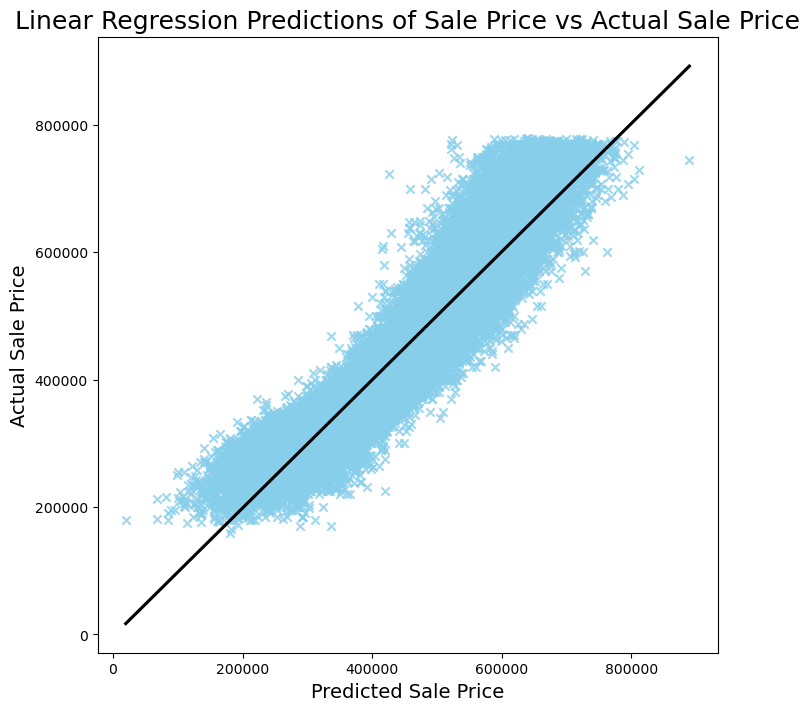

In [34]:
# Create scatterplot to show predicted values versus actual values

plt.figure(figsize=(8,8))
sns.regplot(data=X_train, x=lr_y_pred, y=y_test, marker='x', color='skyblue', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Linear Regression Predictions of Sale Price vs Actual Sale Price', fontsize=18)

The linear regression model shows clear signs of overfitting based on the large differences in individual cross-validation scores, and coefficients are highly overblown. Even though the root mean squared error is low, the model's interpretability is low and is less helpful for identifying factors that best predict housing prices.

Let's try Ridge Regression to see if regularization can help with penalising the coefficients of predictors to reduce model complexity and overfitting.

### Ridge Regression

In [35]:
# finding the optimal alpha 

ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train, y_train)

print (optimal_ridge.alpha_)

1.0


In [36]:
# fitting to the model and getting R^2 scores

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)

print ('Cross-Validation scores:', ridge_scores)
print ('Mean Cross-Validation score:', np.mean(ridge_scores))

Cross-Validation scores: [0.86807644 0.87200538 0.86682939 0.8673404  0.87321524 0.86977441
 0.86859013 0.87227527 0.87301964 0.87291066]
Mean Cross-Validation score: 0.8704036959470548


In [37]:
ridge.fit(X_train, y_train)

Ridge()

In [38]:
print("Training score:", ridge.score(X_train, y_train))
print("Test score:", ridge.score(X_test, y_test))

Training score: 0.8706690040892798
Test score: 0.8713085056108281


In [39]:
# Predictions using Ridge
ridge_y_pred = ridge.predict(X_test)
pd.DataFrame(ridge_y_pred).head()

0
0  454294.788947
1  453855.238220
2  289346.552206
3  428397.762342
4  395465.718029

In [40]:
# RMSE 

print("Ridge Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test,ridge_y_pred)))

Ridge Root Mean Squared Error: 43366.096135552914


In [41]:
# R-Squared

print("R-Squared:", metrics.r2_score(y_test, ridge_y_pred))

R-Squared: 0.8713085056108281


Text(0.5, 1.0, 'Ridge Regression Predictions of Sale Price vs Actual Sale Price')

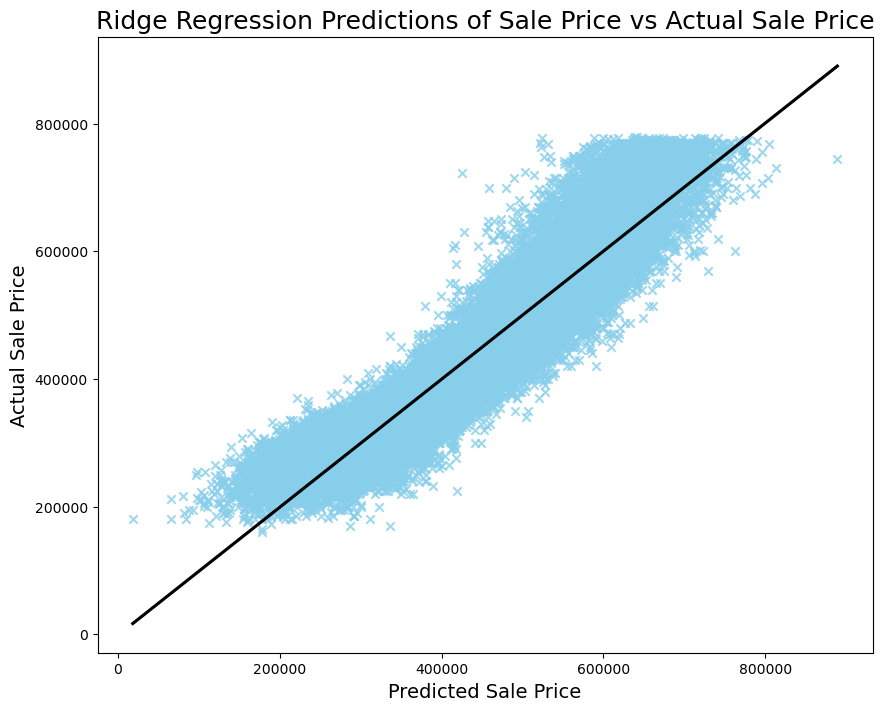

In [42]:
# Create scatterplot to show predicted values versus actual values

plt.figure(figsize=(10,8))
sns.regplot(data=X_train, x=ridge_y_pred, y=y_test, marker='x', color='skyblue', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Ridge Regression Predictions of Sale Price vs Actual Sale Price', fontsize=18)

This time the model doesn't overfit, and the RMSE remains low. But perhaps more can done to improve the accuracy of the model and removing variables that do not explain much of the variance in resale price. We try L1 regularisation to see if a Lasso regression could perform automated feature selection and pick variables that are best at predicting resale prices. 

### Lasso Regression

In [43]:
# Using LassoCV to obtain the optimal alpha

optimal_lasso = LassoCV(n_alphas=1000, cv=10)
optimal_lasso.fit(X_train, y_train)

print (optimal_lasso.alpha_)

270.3577252900522


/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.741e+11, tolerance: 1.486e+11
  model = cd_fast.enet_coordinate_descent(


In [44]:
# Running cross-validation

lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)

print ('Cross-Validation scores:', lasso_scores)
print ('Cross-Validation mean score:', np.mean(lasso_scores))

/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.862e+11, tolerance: 1.336e+11
  model = cd_fast.enet_coordinate_descent(
/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.873e+11, tolerance: 1.340e+11
  model = cd_fast.enet_coordinate_descent(
/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

Cross-Validation scores: [0.85425733 0.85698054 0.85198388 0.85391923 0.85920978 0.85536858
 0.85495291 0.85820949 0.86053121 0.86033673]
Cross-Validation mean score: 0.8565749671165982


/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.868e+11, tolerance: 1.337e+11
  model = cd_fast.enet_coordinate_descent(


Minimal overfitting 

In [45]:
lasso.fit(X_train, y_train)

/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.741e+11, tolerance: 1.486e+11
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=270.3577252900522)

In [46]:
print("Training set score:", lasso.score(X_train, y_train))
print("Test set score:", lasso.score(X_test, y_test))

Training set score: 0.8567702717377023
Test set score: 0.8575670567131846


In [47]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)
                           })

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.head(20)

variable           coef       abs_coef
82  planning_area_Marine Parade  100884.249448  100884.249448
96      planning_area_Woodlands  -92130.755002   92130.755002
1               floor_area_sqft   85579.571573   85579.571573
89      planning_area_Sembawang  -81108.302505   81108.302505
41              flat_model_DBSS   75006.497391   75006.497391
71  planning_area_Bukit Panjang  -59096.990442   59096.990442
97         planning_area_Yishun  -58135.103690   58135.103690
74  planning_area_Choa Chu Kang  -55332.756837   55332.756837
87     planning_area_Queenstown   54479.389504   54479.389504
68         planning_area_Bishan   53632.470559   53632.470559
80    planning_area_Jurong West  -52509.446988   52509.446988
37          flat_type_EXECUTIVE   46339.251869   46339.251869
70    planning_area_Bukit Merah   45777.316004   45777.316004
65              Tranc_Year_2021   43522.722499   43522.722499
16                  age_at_sale  -43126.284863   43126.284863
75       planning_area_Clementi   39340.771235   39340.771235
90       planning_area_Sengkang  -21380.045166   21380.045166
8          mrt_nearest_distance  -21113.944737   21113.944737
34             flat_type_3 ROOM  -20348.153784   20348.153784
57              Tranc_Year_2013   19562.032373   19562.032373

In [48]:
# Predictors that were removed

lasso_coefs[lasso_coefs['abs_coef'] == 0]

variable  coef  abs_coef
43         flat_model_Improved-Maisonette   0.0       0.0
83                   planning_area_Novena   0.0       0.0
13                       1_2_3_rooms_sold  -0.0       0.0
33                       flat_type_2 ROOM   0.0       0.0
76            planning_area_Downtown Core   0.0       0.0
77                  planning_area_Geylang   0.0       0.0
79              planning_area_Jurong East  -0.0       0.0
81                  planning_area_Kallang   0.0       0.0
7                    hawker_market_stalls   0.0       0.0
85                planning_area_Pasir Ris  -0.0       0.0
84                   planning_area_Outram  -0.0       0.0
72              planning_area_Bukit Timah   0.0       0.0
86                  planning_area_Punggol   0.0       0.0
88                   planning_area_Rochor  -0.0       0.0
5                       Hawker_Within_2km   0.0       0.0
32                            age_at_sale  -0.0       0.0
31                        est_floor_level   0.0       0.0
93                  planning_area_Tanglin   0.0       0.0
94                planning_area_Toa Payoh  -0.0       0.0
95  planning_area_Western Water Catchment  -0.0       0.0
73                   planning_area_Changi   0.0       0.0
14                   4_5_other_rooms_sold   0.0       0.0
40                   flat_model_Apartment   0.0       0.0
17                        floor_area_sqft   0.0       0.0
46          flat_model_Model A-Maisonette   0.0       0.0
47                    flat_model_Model A2  -0.0       0.0
48            flat_model_Multi Generation   0.0       0.0
22                     hawker_food_stalls   0.0       0.0
39               flat_model_Adjoined flat   0.0       0.0
51      flat_model_Premium Apartment Loft   0.0       0.0
52          flat_model_Premium Maisonette   0.0       0.0
53                  flat_model_Simplified   0.0       0.0
54                    flat_model_Standard  -0.0       0.0
55                     flat_model_Terrace   0.0       0.0
56                     flat_model_Type S1   0.0       0.0
38             flat_type_MULTI-GENERATION   0.0       0.0
58                        Tranc_Year_2014   0.0       0.0
24                   mrt_nearest_distance  -0.0       0.0
36                       flat_type_5 ROOM   0.0       0.0
28                      distance_from_CBD  -0.0       0.0
63                        Tranc_Year_2019  -0.0       0.0
25              bus_stop_nearest_distance   0.0       0.0
19                        Mall_Within_2km   0.0       0.0
26               pri_sch_nearest_distance   0.0       0.0
67                    planning_area_Bedok   0.0       0.0
18                  Mall_Nearest_Distance  -0.0       0.0
69              planning_area_Bukit Batok   0.0       0.0
27                   sec_sch_nearest_dist   0.0       0.0

In [49]:
lasso_y_pred = lasso.predict(X_test)
lasso_y_pred

array([468824.24476958, 462780.54155563, 298248.0196046 , ...,
       525694.19684263, 398154.58582524, 420015.00793926])

In [50]:
# Calculating the RMSE 

print("Lasso Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test,lasso_y_pred)))

Lasso Root Mean Squared Error: 45622.66290850244


In [51]:
# R-Squared

print("R-Squared:", metrics.r2_score(y_test, lasso_y_pred))

R-Squared: 0.8575670567131846


In [52]:
# Comparing predictions against the test set

lasso_predicted = pd.DataFrame({'y_hat':lasso.predict(X_test),
                               'y_actual': y_test,
                               'residuals': (y_test - lasso.predict(X_test)),
                               'actual test values': y_test,
                               'predicted values': lasso_y_pred.round(decimals = 1)                             
                              })

lasso_predicted.sort_values('residuals', inplace=True, ascending=False)
lasso_predicted.head(10)

y_hat  y_actual      residuals  actual test values  \
91142   344328.124527  765888.0  421559.875473            765888.0   
119770  362607.507796  760000.0  397392.492204            760000.0   
125222  388000.877443  770000.0  381999.122557            770000.0   
111187  371595.911709  750000.0  378404.088291            750000.0   
47710   375899.165665  750000.0  374100.834335            750000.0   
79367   386163.326216  735000.0  348836.673784            735000.0   
139582  356593.738392  660000.0  303406.261608            660000.0   
16853   382879.246875  678000.0  295120.753125            678000.0   
92492   433250.477894  723000.0  289749.522106            723000.0   
6417    500048.722629  775000.0  274951.277371            775000.0   

        predicted values  
91142           344328.1  
119770          362607.5  
125222          388000.9  
111187          371595.9  
47710           375899.2  
79367           386163.3  
139582          356593.7  
16853           382879.2  
92492           433250.5  
6417            500048.7

Text(0.5, 1.0, 'Lasso Predictions of Sale Price vs Actual Sale Price')

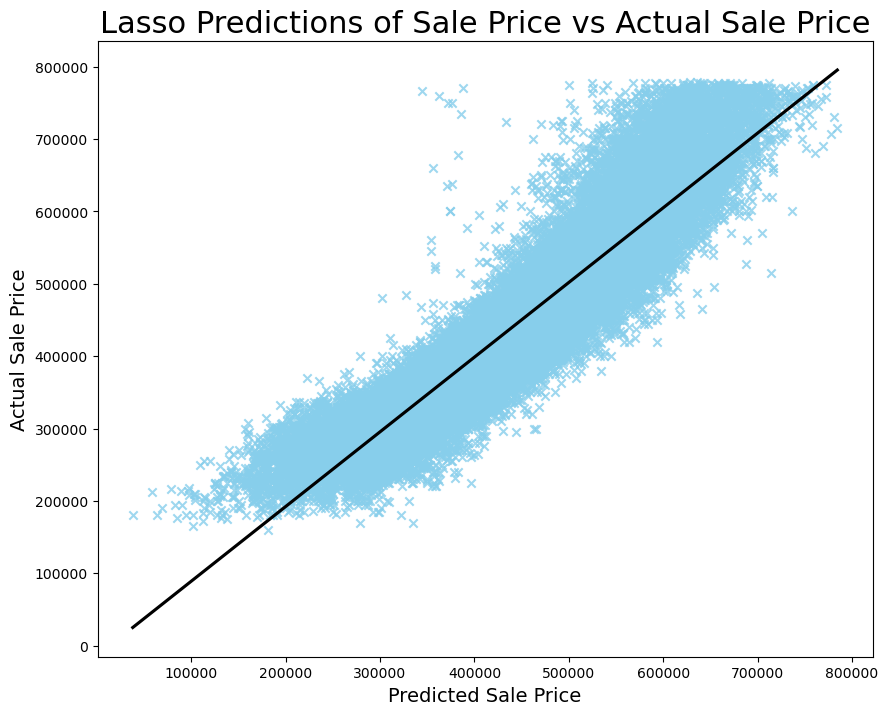

In [53]:
# Create scatterplot to show predicted values versus actual values


plt.figure(figsize=(10,8))
sns.regplot(data=X_train, x=lasso_y_pred, y=y_test, marker='x', color='skyblue', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Lasso Predictions of Sale Price vs Actual Sale Price', fontsize=22)

RMSE of the Lasso Regression is higher than the Ridge Regression 0.081 vs 0.080. 

### ElasticNet

In [54]:
# Finding the optimal alpha and l1 ratio

l1_ratios = np.linspace(0.01, 1.0, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=1000, cv=10)
optimal_enet.fit(X_train, y_train)

print (f'Optimal alpha: {optimal_enet.alpha_}')
print (f'Optimal L1 ratio: {optimal_enet.l1_ratio_}')


Optimal alpha: 270.3577252900522
Optimal L1 ratio: 1.0


/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.741e+11, tolerance: 1.486e+11
  model = cd_fast.enet_coordinate_descent(


In [55]:
# fitting the model

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, X_train, y_train, cv=10)

print ("Cross-Validation scores: ", enet_scores)
print ("Cross-Validation mean score: ", np.mean(enet_scores))

/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.862e+11, tolerance: 1.336e+11
  model = cd_fast.enet_coordinate_descent(
/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.873e+11, tolerance: 1.340e+11
  model = cd_fast.enet_coordinate_descent(
/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

Cross-Validation scores:  [0.85425733 0.85698054 0.85198388 0.85391923 0.85920978 0.85536858
 0.85495291 0.85820949 0.86053121 0.86033673]
Cross-Validation mean score:  0.8565749671165982


/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.868e+11, tolerance: 1.337e+11
  model = cd_fast.enet_coordinate_descent(


In [56]:
enet.fit(X_train, y_train)

/Users/kh/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.741e+11, tolerance: 1.486e+11
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=270.3577252900522, l1_ratio=1.0)

In [57]:
print("Training set scores: ", enet.score(X_train, y_train))
print("Test set scores: ", enet.score(X_test, y_test))

Training set scores:  0.8567702717377023
Test set scores:  0.8575670567131846


In [58]:
enet_y_pred = enet.predict(X_test)

In [59]:
print("ElasticNet Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test,enet_y_pred)))

ElasticNet Root Mean Squared Error: 45622.66290850244


In [60]:
# R-Squared

print("R-Squared:", metrics.r2_score(y_test, enet_y_pred))

R-Squared: 0.8575670567131846


In [61]:
# Predicting on the test set

enet_predicted = pd.DataFrame({'y_hat':enet.predict(X_test),
                               'y_actual': y_test,
                               'residuals': (y_test - enet.predict(X_test)),
                               'actual test values': y_test,
                               'predicted values': enet_y_pred.round(decimals = 1)                             
                              })

enet_predicted.sort_values('residuals', inplace=True, ascending=False)
enet_predicted.head(10)

y_hat  y_actual      residuals  actual test values  \
91142   344328.124527  765888.0  421559.875473            765888.0   
119770  362607.507796  760000.0  397392.492204            760000.0   
125222  388000.877443  770000.0  381999.122557            770000.0   
111187  371595.911709  750000.0  378404.088291            750000.0   
47710   375899.165665  750000.0  374100.834335            750000.0   
79367   386163.326216  735000.0  348836.673784            735000.0   
139582  356593.738392  660000.0  303406.261608            660000.0   
16853   382879.246875  678000.0  295120.753125            678000.0   
92492   433250.477894  723000.0  289749.522106            723000.0   
6417    500048.722629  775000.0  274951.277371            775000.0   

        predicted values  
91142           344328.1  
119770          362607.5  
125222          388000.9  
111187          371595.9  
47710           375899.2  
79367           386163.3  
139582          356593.7  
16853           382879.2  
92492           433250.5  
6417            500048.7

Text(0.5, 1.0, 'ElasticNet Predictions of Sale Price vs Actual Sale Price')

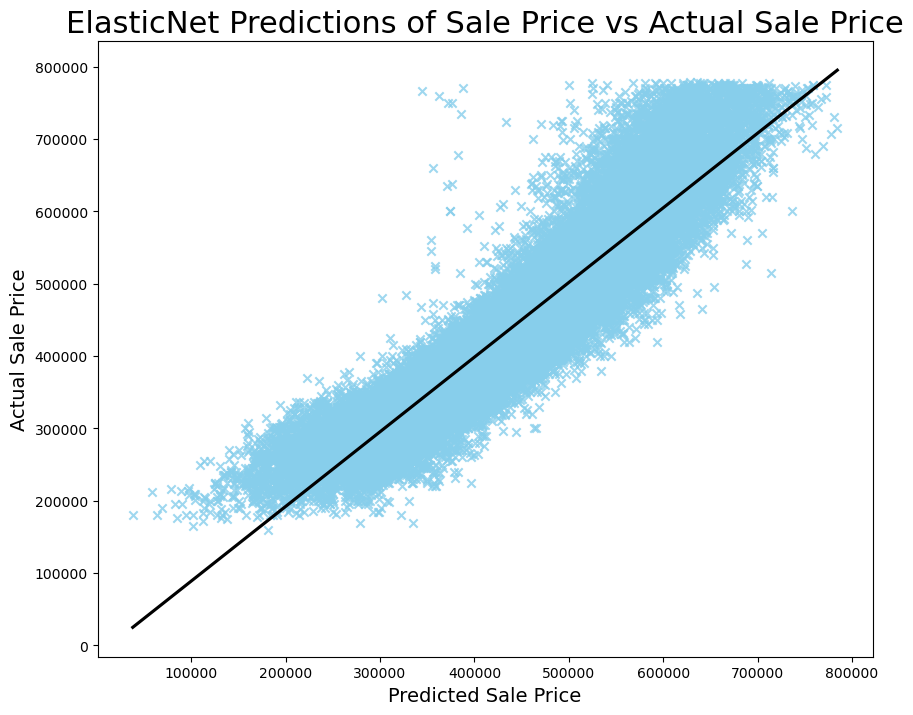

In [62]:
# Create scatterplot to show predicted values versus actual values 

plt.figure(figsize=(10,8))
sns.regplot(data=X_train, x=enet_y_pred, y=y_test, marker='x', color='skyblue', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('ElasticNet Predictions of Sale Price vs Actual Sale Price', fontsize=22)

---

### Review

**Comparison between the 3 Models**:

Presence of overfitting:
Linear Regression : Yes
Ridge Regression Root Mean Squared Error: No
Lasso Regression Root Mean Squared Error: No
ElasticNet Regression Root Mean Squared Error: No

Root Mean Squared Error:
Linear Regression : 0.0805
Ridge Regression Root Mean Squared Error: 0.0805
Lasso Regression Root Mean Squared Error: 0.0812
ElasticNet Regression Root Mean Squared Error: 0.0812

R-Squared Scores:
Linear Regression : 0.0805
Ridge Regression Root Mean Squared Error: 0.0805
Lasso Regression Root Mean Squared Error: 0.0812
ElasticNet Regression Root Mean Squared Error: 0.0812

- Baseline linear regression model performed most poorly with inflated coefficients, overfitting (evident in the cross-validation scores), and 
- Ridge, Lasso and ElasticNet perform similarly in terms of R^2 scores (about 87%)
- Strongest predictors: floor area, age, distance to mrt and hawkers, whether the estate is in Woodlands and floor level

**Interpretation:**

<ol>
    <li> With every one unit increase in floor area, resale price is estimated to increase by SGD 85K </li>
    <li>  With every one unit increase in lease commence date, the resale price is estimated to increase by SGD47K</li>
    <li>Compared to houses in Kallang, resale prices in Woodlands, Jurong East, Sembawang, Choa Chu Kang are estimated to be SGD 20K - 36K lower, while prices in Marine Parade, Bishan, Bt Merah and Queenstown are estimated to be SGD 11k - 15k higher. </li>
    <li>With every 1 unit increase in distance from mrt and hawker centres, the resale price is estimated to decrease by SGD 25K and SGD 23K respectively.</li>
    <li>With every 1 unit increase in the estimated height of the house relative to the highest storey, the resale price is estimated to increase by SGD 15k.</li>
</ol>


**Conclusion and Recommendations**

- Houses with larger floor area, have longer remaining lease periods, which are closer to hawker centres and mrt stations, and are mature estates located closer to central area tend to fetch higher resale prices.
- On the flipside, houses located far away from the city centre have lower resale prices. 

- The results indicate that people value having a larger and newer home, which allows owners to have more flexibilty in terms of family planning or rental. 
- Accessibility to public transport (mrt stations) and cheap F&B options (hawkers) are important factors that impact day-to-day activities such as commuting and overall cost of living. 
- Keeping these needs and preferences in mind when attempting to market or sell a house would be useful, by emphasising on the property's strengths and downplaying its weaknesses. 

Future Steps
- TBC

